### SSAM segmentation-free analysis script for Xenuim-benchmarking analysis

Salas et al, 2023

Analysis performed by Sebastian Tiesmeyer from Berlin Institute of Health.
sebastian.tiesmeyer@bih-charite.de
 

In [2]:

import os

import pandas as pd
import anndata
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import ssam


#### Parameter definitions:

In [3]:
### Global variables:

n_slide = 1  # [can be 1-3]

### SSAM analysis:

# KDE

ssam_vf_um_per_px = 2.0
kde_bandwidth_um = 2.5

# localmax detection:
norm_thres = 5
exp_thres = 0.2
min_dist = 7

### Prepare paths/locations:

data_path = '/dh-projects/ag-ishaque/raw_data/Xenium-benchmark'


#### Load scRNAseq data:

In [4]:
# adata_sc = anndata.read_h5ad(os.path.join(data_path,'scRNAseq/allen_brain_atlas_prepared_by_Sergio/WMB-10Xv2-subset02_ready_for_xenium_benchmark.h5ad'))
# color_df = pd.read_csv(os.path.join(data_path,'scRNAseq/allen_brain_atlas_prepared_by_Sergio/WMB-10Xv2-subset02_ready_for_xenium_benchmark_colors.csv'), index_col=0)

# adata_sc

#### Data loader:

Xenium spots:

In [5]:

# coordinate data exists inside the anndata object's uns['spots'] field:
adata = anndata.read_h5ad(os.path.join(data_path, 'spatial',f'ms_brain_multisection{n_slide}.h5ad'))
coordinate_df = adata.uns['spots'].copy()[['x_location', 'y_location','z_location','feature_name']]
coordinate_df.columns = ['x', 'y', 'z', 'gene']
coordinate_df['z']*= 0
coordinate_df = coordinate_df[~(coordinate_df.gene.str.contains("BLANK") | coordinate_df.gene.str.contains("NegControl"))]
coordinate_df['gene'] = coordinate_df['gene'].astype('category')


# shift coordinates to be positive:
coordinate_df[['x', 'y', 'z']] = coordinate_df[['x', 'y', 'z']] - coordinate_df[['x', 'y', 'z']].min()

# get a list of all genes for convenience:
genes = coordinate_df['gene'].cat.categories.tolist()
genes

['2010300C02Rik',
 'Acsbg1',
 'Acta2',
 'Acvrl1',
 'Adamts2',
 'Adamtsl1',
 'Adgrl4',
 'Aldh1a2',
 'Angpt1',
 'Ano1',
 'Aqp4',
 'Arc',
 'Arhgap12',
 'Arhgap25',
 'Arhgap6',
 'Arhgef28',
 'Bcl11b',
 'Bdnf',
 'Bhlhe22',
 'Bhlhe40',
 'Btbd11',
 'Cabp7',
 'Cacna2d2',
 'Calb1',
 'Calb2',
 'Car4',
 'Carmn',
 'Cbln1',
 'Cbln4',
 'Ccn2',
 'Cd24a',
 'Cd300c2',
 'Cd44',
 'Cd53',
 'Cd68',
 'Cd93',
 'Cdh13',
 'Cdh20',
 'Cdh4',
 'Cdh6',
 'Cdh9',
 'Chat',
 'Chodl',
 'Chrm2',
 'Cldn5',
 'Clmn',
 'Cntn6',
 'Cntnap4',
 'Cntnap5b',
 'Cobll1',
 'Col19a1',
 'Col1a1',
 'Col6a1',
 'Cort',
 'Cplx3',
 'Cpne4',
 'Cpne6',
 'Cpne8',
 'Crh',
 'Cspg4',
 'Cux2',
 'Cwh43',
 'Cyp1b1',
 'Dcn',
 'Deptor',
 'Dkk3',
 'Dner',
 'Dpy19l1',
 'Dpyd',
 'Ebf3',
 'Emcn',
 'Epha4',
 'Eya4',
 'Fezf2',
 'Fgd5',
 'Fhod3',
 'Fibcd1',
 'Fign',
 'Fmod',
 'Fn1',
 'Fos',
 'Foxp2',
 'Gad1',
 'Gad2',
 'Gadd45a',
 'Galnt14',
 'Garnl3',
 'Gfap',
 'Gfra2',
 'Gjb2',
 'Gjc3',
 'Gli3',
 'Gm19410',
 'Gm2115',
 'Gng12',
 'Gpr17',
 'Grik3',
 'Gsg1l

In [6]:
# adata object with current celltype assignments:
adata_annotated_dapi = anndata.read_h5ad("/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/spatial/adata_multisection_nuclei_3rep_withHM_withclusters.h5ad")

adata_annotated_dapi = adata_annotated_dapi[adata_annotated_dapi.obs.replicate==str(n_slide)]

cell_meta_df = adata_annotated_dapi.obs.copy()

celltypes = cell_meta_df.Class.cat.categories.tolist()

signatures_snrna = pd.DataFrame(index=adata_annotated_dapi.var.index, columns=celltypes)
signatures_snrna.iloc[:] = 0

for celltype in tqdm.tqdm(celltypes):
    signatures_snrna.loc[:,celltype] = list(adata_annotated_dapi[cell_meta_df.Class==celltype].X.mean(axis=0))

signatures_snrna = signatures_snrna.loc[genes,:]

signatures_snrna = np.log(signatures_snrna+1)

color_series = pd.Series(adata_annotated_dapi.uns['Class_colors'],index=cell_meta_df.Class.cat.categories)

cell_meta_df.head()

/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
  0%|                                                                                                | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_316304/1911690169.py:14: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  signatures_snrna.loc[:,celltype] = list(adata_annotated_dapi[cell_meta_df.Class==celltype].X.mean(axis=0))
100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 71.83it/s]


cell_id   x_centroid   y_centroid  transcript_counts  \
ind                                                         
1          1  1557.532239  2528.022437                327   
2          2  1560.669312  2543.632678                354   
3          3  1570.462885  2530.810461                422   
4          4  1573.927734  2546.454529                250   
5          5  1581.344379  2557.024951                550   

     control_probe_counts  control_codeword_counts  total_counts   cell_area  \
ind                                                                            
1                       0                        0           327  240.953750   
2                       0                        0           354  211.692500   
3                       0                        0           422  186.946875   
4                       0                        0           250  239.237812   
5                       1                        0           550  438.692969   

     nucleus_area replicate  ...  leiden_2_2  leiden_1_4 leiden_0_6  \
ind                          ...                                      
1       63.038125         1  ...          25          24          5   
2       65.476562         1  ...          54          14         14   
3       69.540625         1  ...          25          24          5   
4       61.728594         1  ...           1           1          1   
5       92.209063         1  ...          25          24          5   

               X             Y    X_umap     Y_umap  dataset_source  \
ind                                                                   
1    7329.559812  11896.570224  9.827806   7.383136         preview   
2    7344.322500  11970.030148  5.984451   3.733681         preview   
3    7390.409879  11909.690334  9.747280   7.347030         preview   
4    7406.715047  11983.309438  6.836078 -13.070249         preview   
5    7441.616885  12033.052577  9.689524   7.293010         preview   

     nucleus_prop               Class  
ind                                    
1        0.261619  LA-BLA-BMA-PA Glut  
2        0.309300          Pvalb Gaba  
3        0.371981  LA-BLA-BMA-PA Glut  
4        0.258022          Astrocytes  
5        0.210190  LA-BLA-BMA-PA Glut  

[5 rows x 22 columns]

/tmp/ipykernel_316304/1794191601.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cell_meta_df.X,cell_meta_df.Y,c=color_series[cell_meta_df.Class],cmap='nipy_spectral',s=1,alpha=0.5)


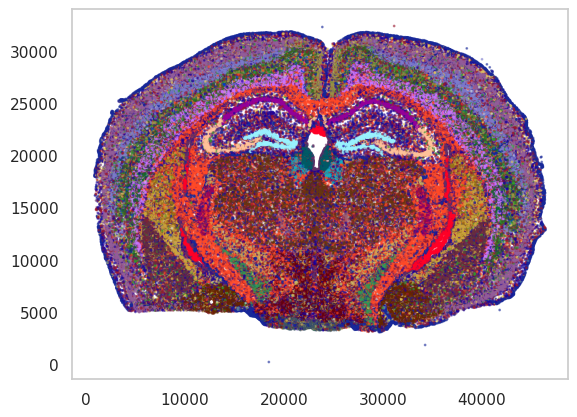

In [7]:
plt.scatter(cell_meta_df.X,cell_meta_df.Y,c=color_series[cell_meta_df.Class],cmap='nipy_spectral',s=1,alpha=0.5)

#### SSAM analysis:

Data preperation.

In [8]:

mrna_loci = []

print("Formatting coordinates for SSAM...")
for i,g in tqdm.tqdm(enumerate(genes),total = len(genes)):
    mrna_loci.append(coordinate_df.loc[coordinate_df['gene'] == g, ['x', 'y',]].values/ssam_vf_um_per_px)

x_,_x = coordinate_df['x'].min()/ssam_vf_um_per_px, coordinate_df['x'].max()/ssam_vf_um_per_px
y_,_y = coordinate_df['y'].min()/ssam_vf_um_per_px, coordinate_df['y'].max()/ssam_vf_um_per_px
z_,_z = coordinate_df['z'].min()/ssam_vf_um_per_px, coordinate_df['z'].max()/ssam_vf_um_per_px
height = np.ceil((_x-x_)).astype(int)
width = np.ceil((_y-y_)).astype(int)
depth = np.ceil((_z-z_)).astype(int)

ds = ssam.SSAMDataset(genes,mrna_loci, height, width,)

# del mrna_loci,  coordinate_df
 

Formatting coordinates for SSAM...


100%|█████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:13<00:00, 18.90it/s]


#### create SSAM objects

In [9]:
analysis = ssam.SSAMAnalysis(ds,save_dir='')

In [10]:
analysis.save_dir = ''

In [11]:
analysis.run_fast_kde(bandwidth=kde_bandwidth_um/ssam_vf_um_per_px,  use_mmap=False,re_run=True)

Processing gene Slc17a7...
Processing gene Nrn1...
Processing gene Dner...
Processing gene Epha4...
Processing gene Id2...
Processing gene Rims3...
Processing gene Dpy19l1...
Processing gene Dkk3...
Processing gene Clmn...
Processing gene Acsbg1...
Processing gene 2010300C02Rik...
Processing gene Arc...
Processing gene Slc17a6...
Processing gene Gfap...
Processing gene Garnl3...
Processing gene Necab1...
Processing gene Bhlhe40...
Processing gene Gad1...
Processing gene Cpne4...
Processing gene Cpne6...
Processing gene Ntsr2...
Processing gene Nr2f2...
Processing gene Calb1...
Processing gene Cabp7...
Processing gene Rasgrf2...
Processing gene Neurod6...
Processing gene Rorb...
Processing gene Aqp4...
Processing gene Kctd12...
Processing gene Rmst...
Processing gene Meis2...
Processing gene Nrep...
Processing gene Igfbp5...
Processing gene Plcxd2...
Processing gene Gjc3...
Processing gene Mapk4...
Processing gene Gng12...Processing gene Lamp5...

Processing gene Pde7b...Processing gene

In [12]:
analysis.find_localmax(search_size=min_dist/ssam_vf_um_per_px, min_norm=norm_thres, min_expression=exp_thres)

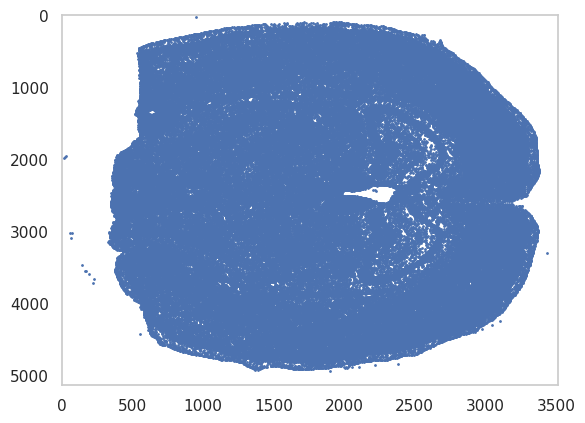

In [13]:
ds.plot_localmax()

In [14]:
analysis.normalize_vectors(normalize_vector=True)

In [15]:
analysis.map_celltypes(signatures_snrna.astype(float).values.T)
analysis.filter_celltypemaps()

/tmp/ipykernel_316304/1798315531.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([(2*(int(l.get_text()))) for i,l in enumerate(plt.gca().get_xticklabels())])
/tmp/ipykernel_316304/1798315531.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([(2*(int(l.get_text()))) for i,l in enumerate(plt.gca().get_yticklabels())])


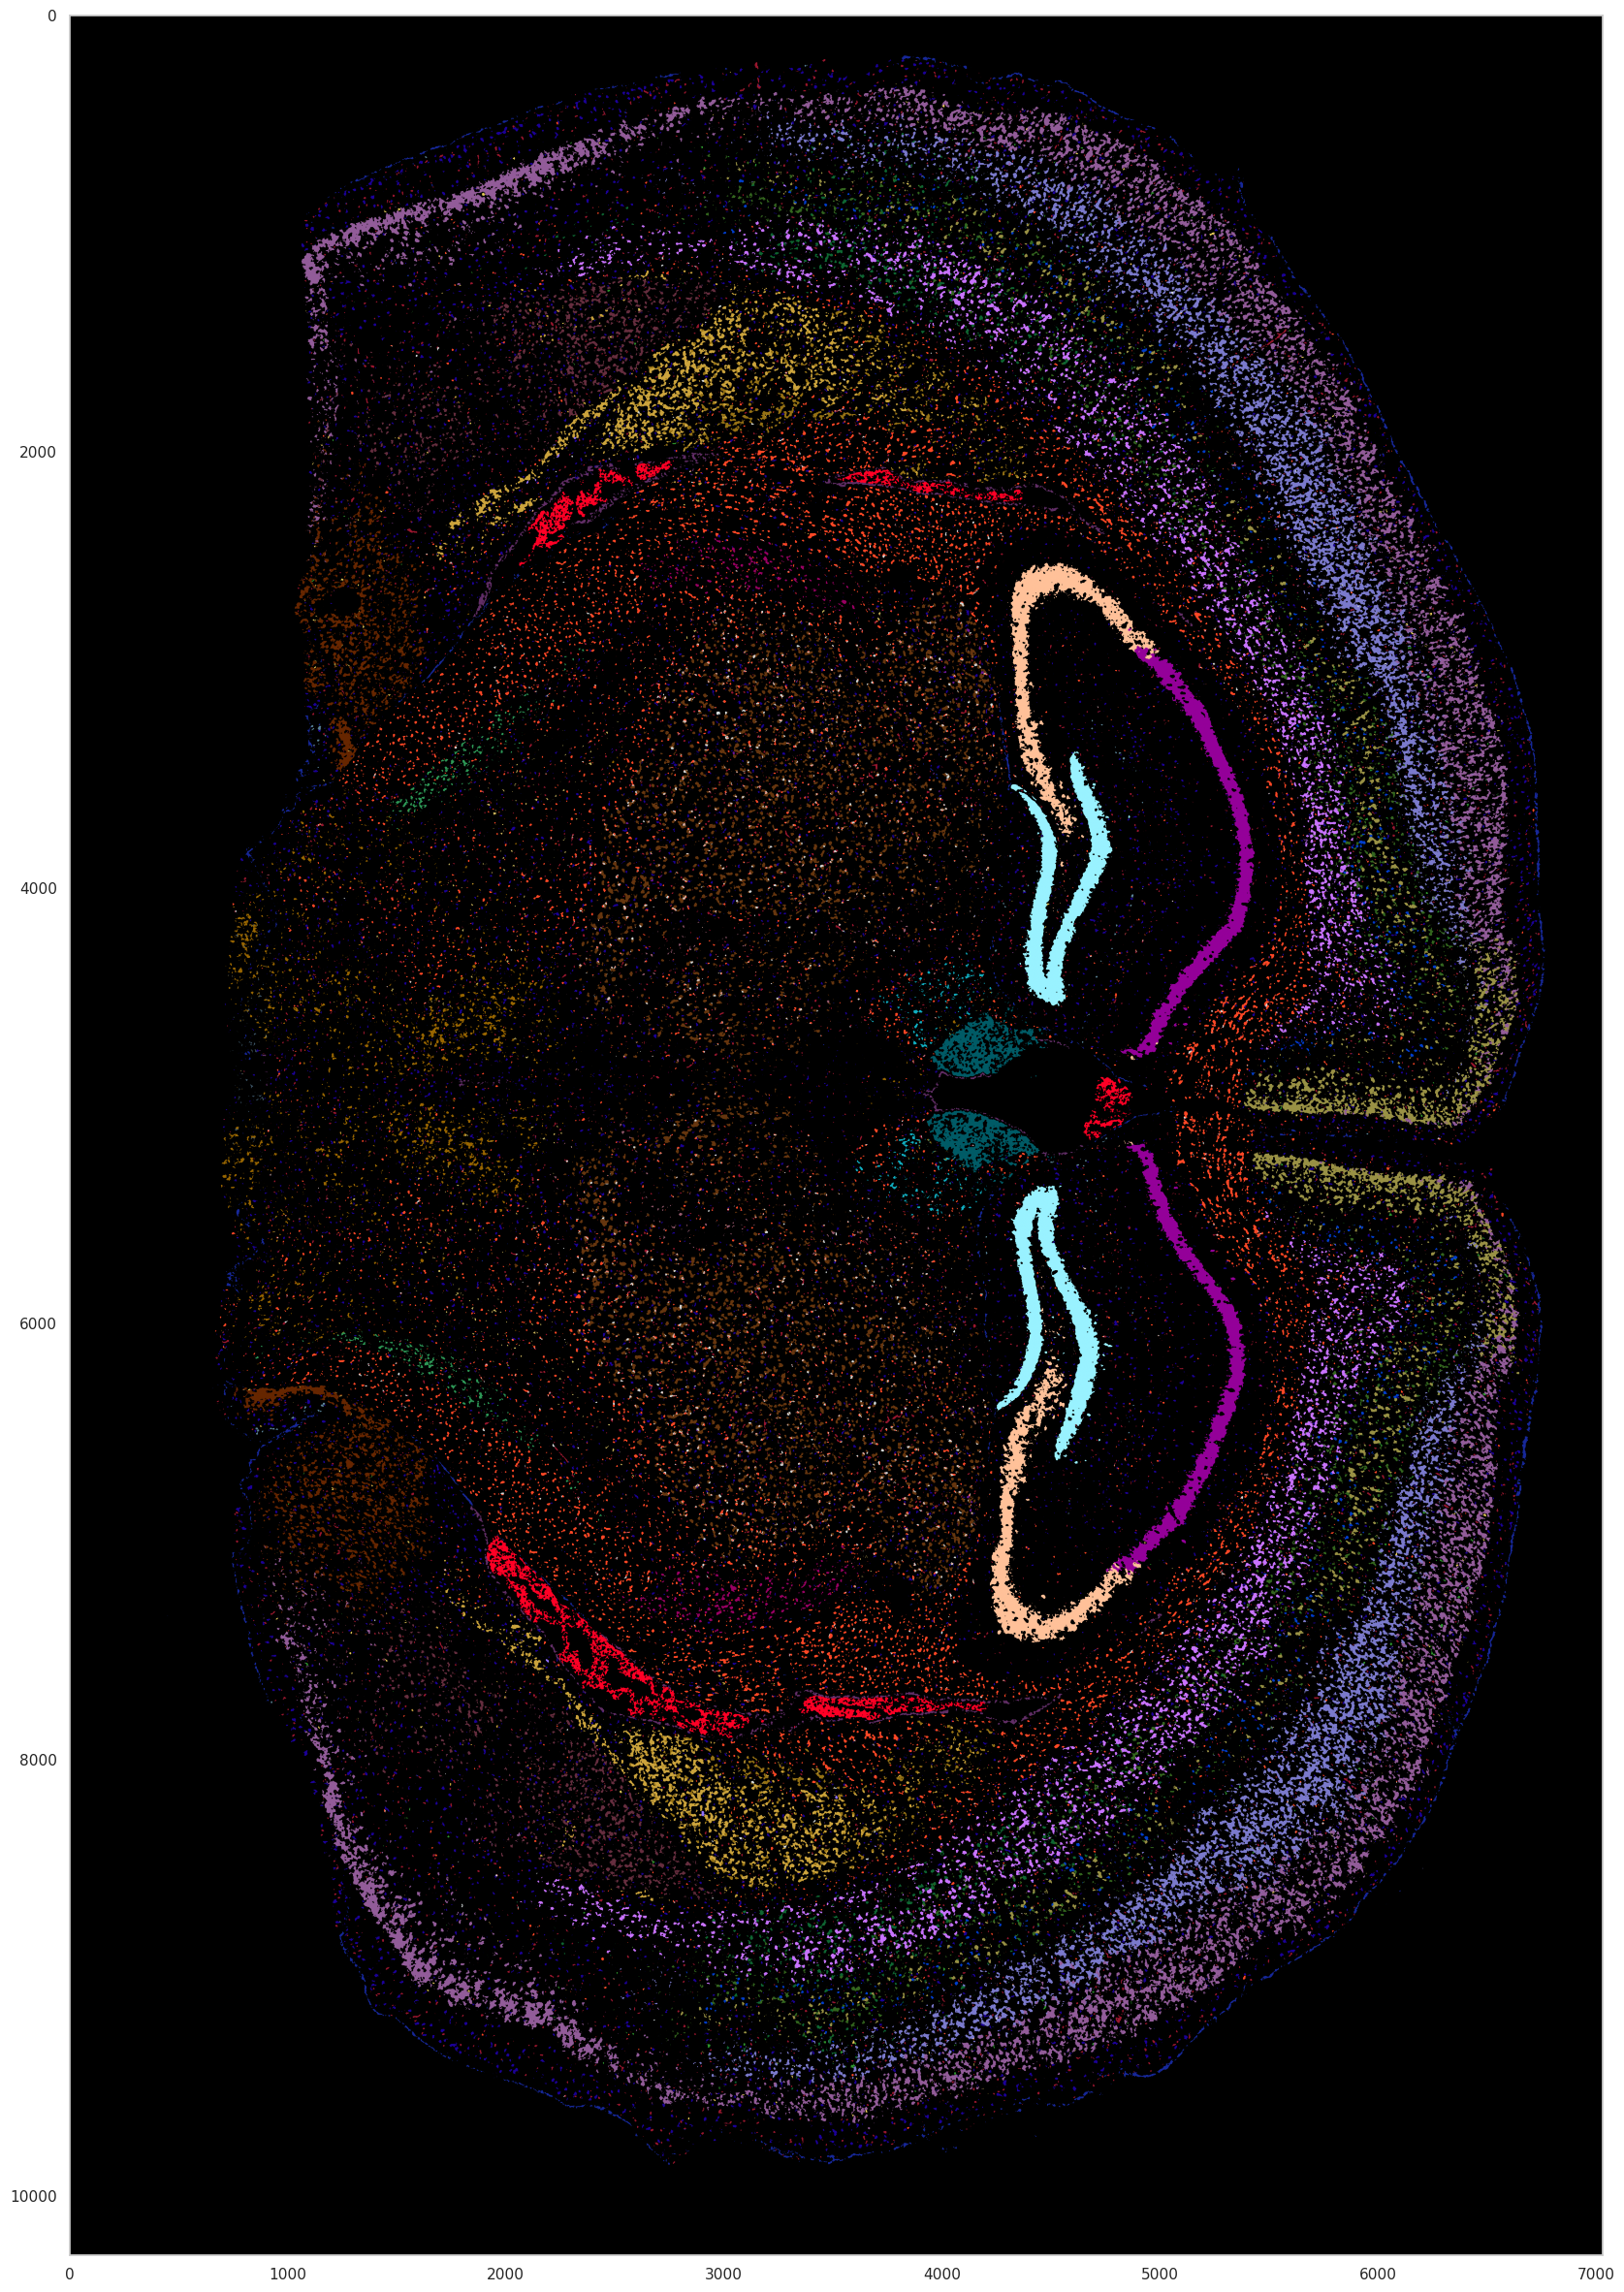

In [16]:
from matplotlib.lines import Line2D
                

plt.figure(figsize=(25,30))
ds.plot_celltypes_map(colors = color_series.values)

plt.xlim(0,None)
plt.ylim(None,0)

plt.gca().set_xticklabels([(2*(int(l.get_text()))) for i,l in enumerate(plt.gca().get_xticklabels())])
plt.gca().set_yticklabels([(2*(int(l.get_text()))) for i,l in enumerate(plt.gca().get_yticklabels())])

# plt.savefig(f'./output/celltype_map_slice_{n_slide}.png',dpi=300,bbox_inches='tight')
plt.savefig(f'./output/celltype_map_slice_{n_slide}.png',dpi=300,bbox_inches='tight')
plt.savefig(f'./output/celltype_map_slice_{n_slide}.pdf',dpi=300,bbox_inches='tight')

In [17]:

import scanpy as sc
import anndata

adata = anndata.AnnData(ds.normalized_vectors,var=pd.DataFrame(index=ds.genes),obs=pd.DataFrame.from_dict({'x':ds.local_maxs[0],'y':ds.local_maxs[1]}))
 

/tmp/ipykernel_316304/110716687.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(ds.normalized_vectors,var=pd.DataFrame(index=ds.genes),obs=pd.DataFrame.from_dict({'x':ds.local_maxs[0],'y':ds.local_maxs[1]}))
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


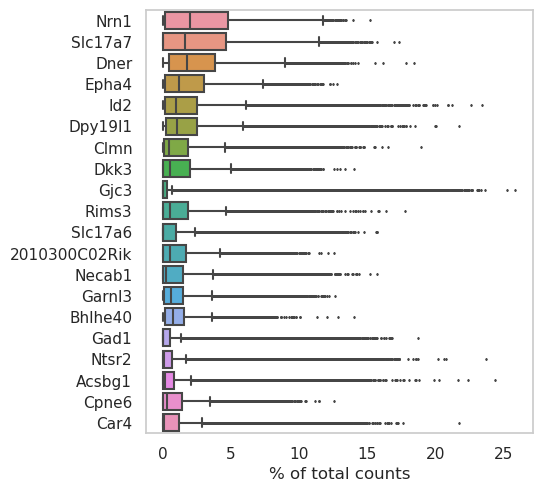

In [18]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


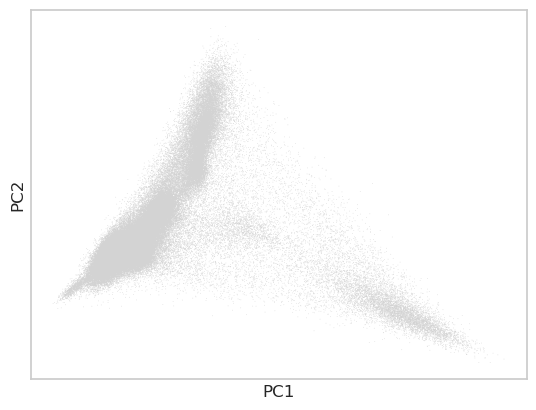

In [20]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata,)

In [21]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

In [22]:
adata.shape

(108783, 248)

In [23]:
sc.tl.umap(adata, min_dist=0.02, random_state=42)

In [24]:
sc.tl.leiden(adata, resolution=2.0, random_state=42)

/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


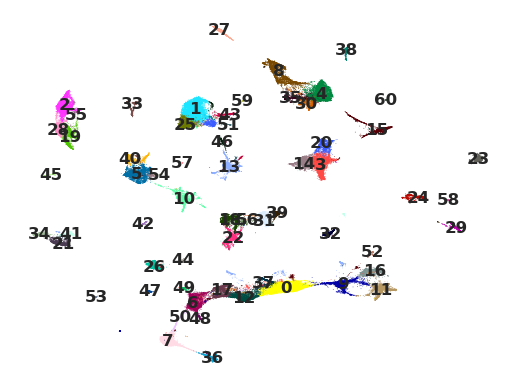

In [25]:
sc.pl.umap(adata, color=['leiden'], legend_loc='on data', title='', frameon=False, save='_leiden.png')

In [26]:

leiden_signatures = pd.DataFrame(index=adata.var.index, columns=adata.obs.leiden.cat.categories)

for celltype in tqdm.tqdm(adata.obs.leiden.cat.categories):
    leiden_signatures.loc[:,celltype] = list(adata[adata.obs.leiden==celltype].X.mean(axis=0))

leiden_signatures = leiden_signatures.loc[genes,:]
leiden_signatures = np.log(leiden_signatures+1)

leiden_celltype_correlations = pd.DataFrame(index=celltypes,columns=adata.obs.leiden.cat.categories)

for celltype in tqdm.tqdm(celltypes):
    for leiden in adata.obs.leiden.cat.categories:
        leiden_celltype_correlations.loc[celltype,leiden] = np.corrcoef(signatures_snrna.loc[:,celltype],leiden_signatures.loc[:,leiden])[0,1]

leiden_celltype_correlations = leiden_celltype_correlations.astype(float)


import seaborn as sns

celltype_assignments = leiden_celltype_correlations.values.argmax(axis=0)
celltype_assignment_names = leiden_celltype_correlations.index[celltype_assignments]
celltype_assignments 


  0%|                                                                                                | 0/61 [00:00<?, ?it/s]

/tmp/ipykernel_316304/2744227040.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  leiden_signatures.loc[:,celltype] = list(adata[adata.obs.leiden==celltype].X.mean(axis=0))
100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 72.55it/s]


array([14, 37, 48,  2,  8, 40, 21, 22, 49, 15, 12, 24, 18, 36,  2, 31, 27,
       18, 43, 48,  2, 29, 43,  7,  4, 37, 19,  6, 48,  3,  8, 13,  5, 25,
       30, 42, 23, 14,  9, 13, 45, 46, 44, 32, 20, 39, 37, 16, 21, 18, 33,
       31,  0, 17, 11, 48, 43, 28,  4,  1, 47])

In [27]:
signatures = np.stack(adata.obs.groupby('leiden').apply(lambda x: np.array(adata[list(x.index)].X.mean(0)).astype(float)))

signatures = pd.DataFrame(signatures.T,index=adata.var.index)

signatures = signatures / (signatures**2).sum(0)**0.5

signatures = np.log(signatures+1)

In [36]:
analysis.map_celltypes(leiden_signatures.astype(float).values.T)
analysis.filter_celltypemaps(min_norm=3,min_r =0.2)

In [49]:
# draw outlines around artist:
import matplotlib.patheffects as PathEffects
 

def draw_outline(ax, artist, lw=2,color='black'):
    path = artist.set_path_effects([PathEffects.withStroke(linewidth=lw, foreground=color), PathEffects.Normal()])

def plot_scalebar(ax,x,y,length=100,fontsize=10,text='100um',color='k',text_offset=20,edge_color=None):
    plot_artist = ax.plot([x,x+length],[y,y],c=color,lw=2)
    text_artist = ax.text(x+length/2,y+text_offset,text,fontsize=fontsize,ha='center',va='bottom',c=color)

    if edge_color is not None:
        draw_outline(ax,plot_artist[0],lw=5,color=edge_color)
        draw_outline(ax,text_artist,lw=5,color=edge_color)

    return plot_artist, text_artist

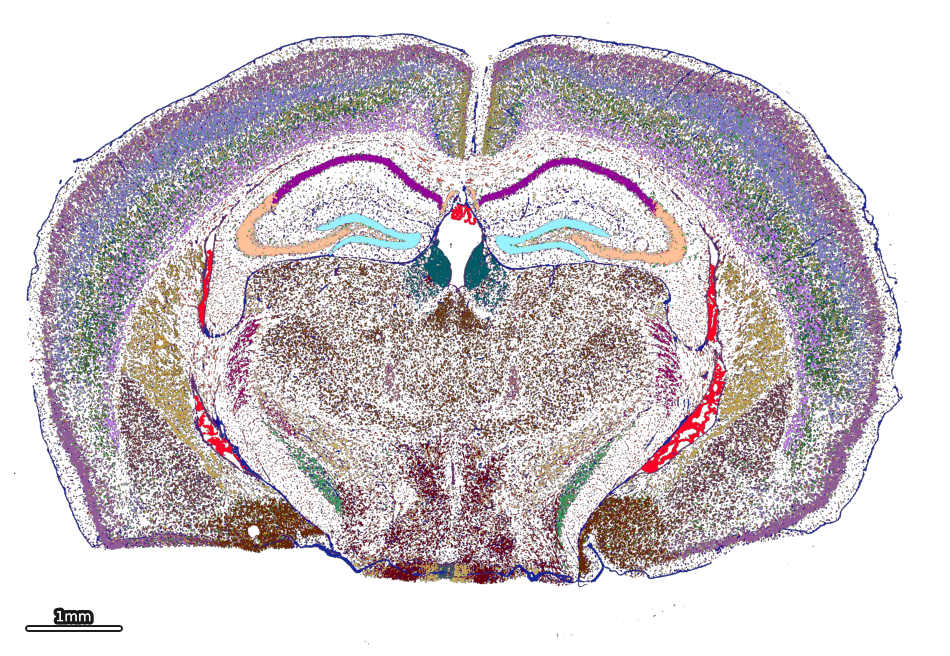

In [50]:
from matplotlib.lines import Line2D
                

plt.figure(figsize=(12,12))
ds.plot_celltypes_map(colors = color_series.iloc[celltype_assignments].values, rotate=3)

plot_scalebar(plt.gca(),100, 100,500,text='1mm',color='w',edge_color='k')

plt.axis('off')

plt.savefig(f'./output/celltype_map_slice_{n_slide}_denovo.png',dpi=300,bbox_inches='tight')
plt.savefig(f'./output/celltype_map_slice_{n_slide}_denovo.pdf',dpi=300,bbox_inches='tight')
plt.savefig(f'./output/celltype_map_slice_{n_slide}_denovo.svg',dpi=300,bbox_inches='tight')

/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


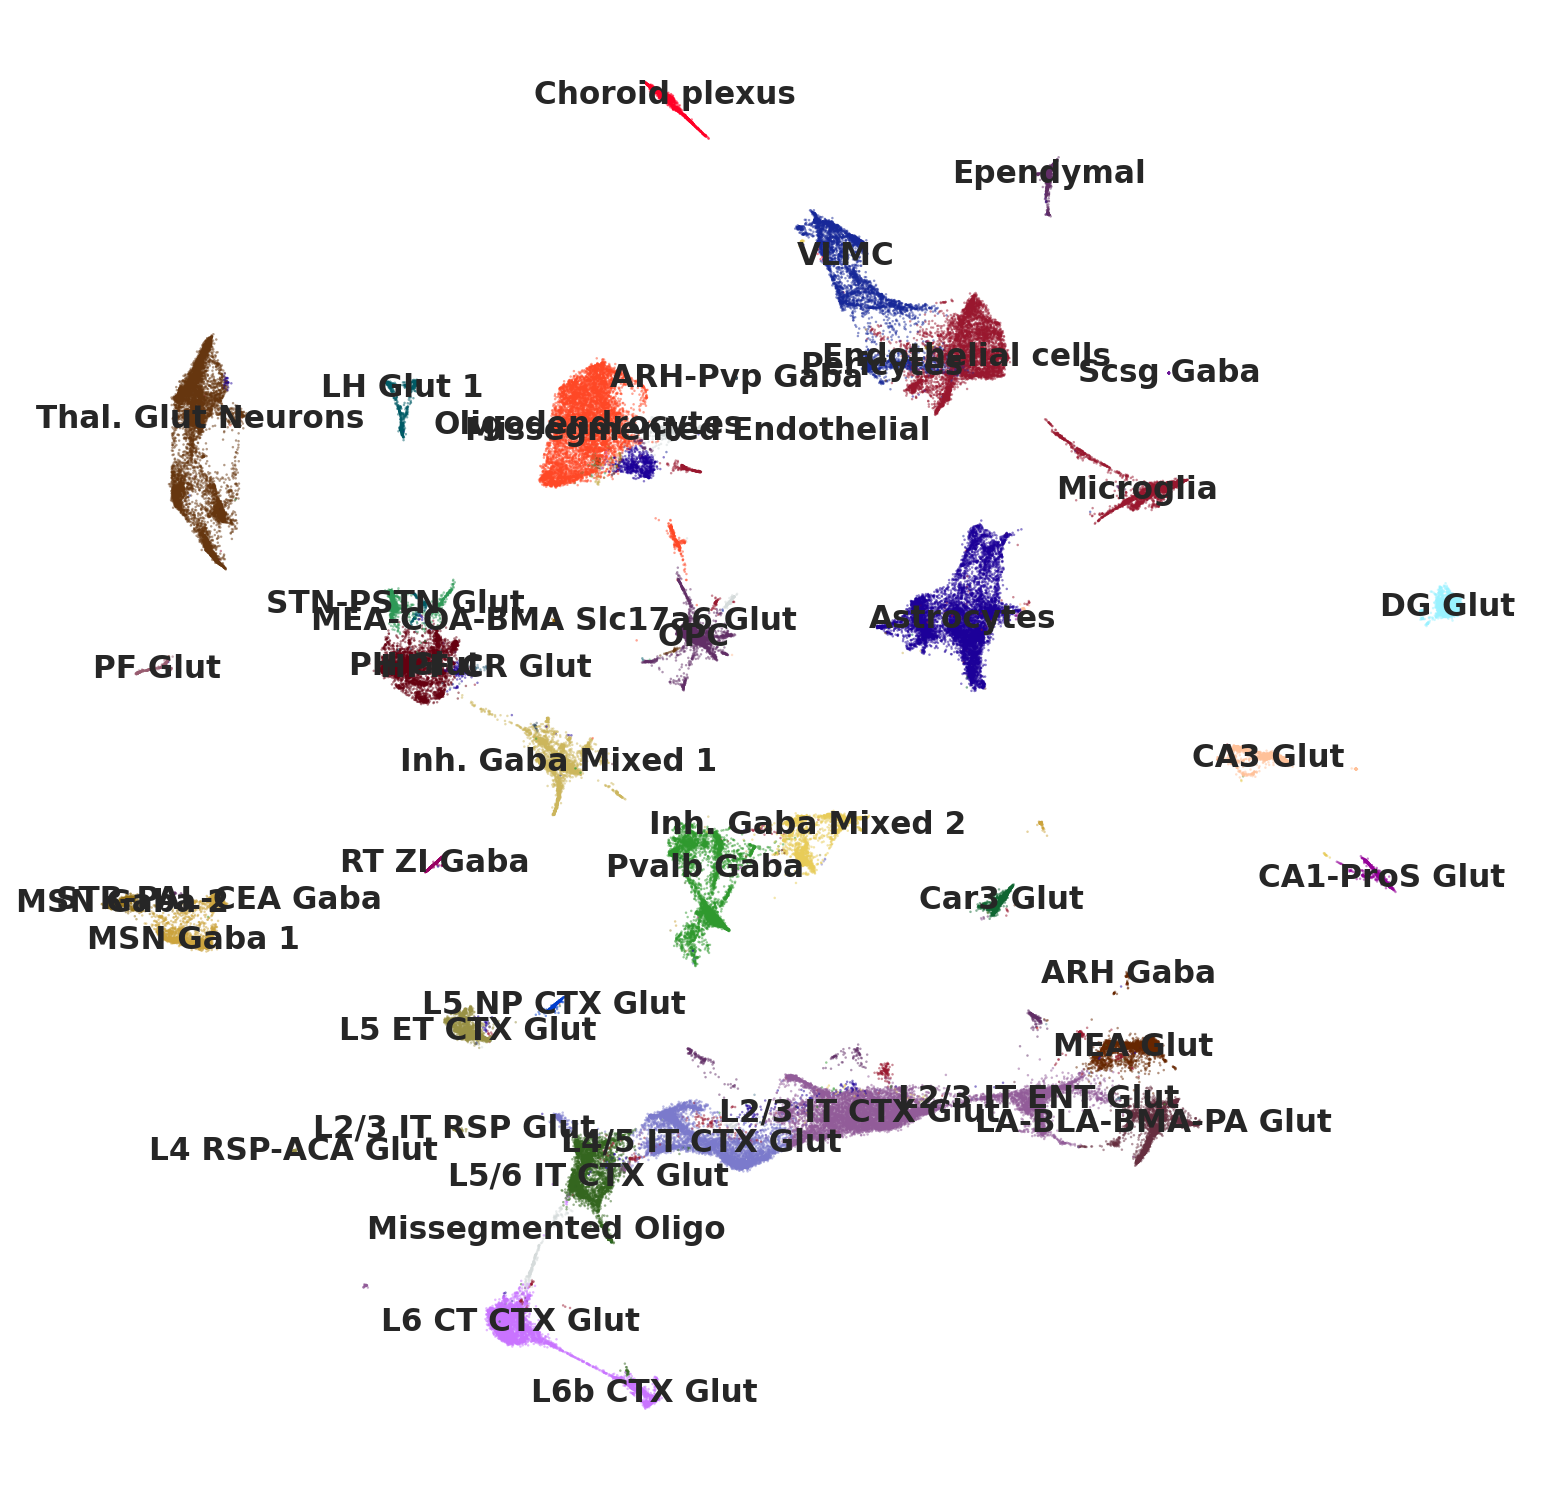

In [59]:
adata.obs['leiden_assignment'] = celltype_assignment_names[adata.obs['leiden'].values.astype(int)].astype('category')

sc.set_figure_params(vector_friendly=True)  

fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111)
sc.pl.umap(adata, color=['leiden_assignment'], legend_loc='on data', title='', s=5, alpha=0.5,
frameon=False, save='_leiden.png', 
palette={str(celltype_assignment_names[i]):c for i,c in enumerate(color_series.iloc[celltype_assignments].values)},ax=ax)

fig.savefig(f'./output/celltype_map_slice_{n_slide}_denovo_umap.png',dpi=300,bbox_inches='tight')
fig.savefig(f'./output/celltype_map_slice_{n_slide}_denovo_umap.pdf',dpi=300,bbox_inches='tight')
fig.savefig(f'./output/celltype_map_slice_{n_slide}_denovo_umap.svg',dpi=300,bbox_inches='tight')


In [31]:
print(celltype_assignment_names.value_counts())
print(len(celltype_assignment_names.value_counts()),leiden_signatures.shape)
print(signatures_snrna.columns ^ celltype_assignment_names)

Thal. Glut Neurons          4
Pvalb Gaba                  3
Oligodendrocytes            3
Astrocytes                  3
L4/5 IT CTX Glut            3
Microglia                   2
CA3 Glut                    2
L2/3 IT CTX Glut            2
L5/6 IT CTX Glut            2
Endothelial cells           2
Inh. Gaba Mixed 2           2
L5 NP CTX Glut              1
STN-PSTN Glut               1
STR-PAL-CEA Gaba            1
RT ZI Gaba                  1
Ependymal                   1
Missegmented Endothelial    1
L2/3 IT RSP Glut            1
PF Glut                     1
Pericytes                   1
Missegmented Oligo          1
ARH Gaba                    1
L4 RSP-ACA Glut             1
HPF CR Glut                 1
MEA-COA-BMA Slc17a6 Glut    1
ARH-Pvp Gaba                1
L6b CTX Glut                1
CA1-ProS Glut               1
MSN Gaba 2                  1
LH Glut 1                   1
Car3 Glut                   1
Choroid plexus              1
L5 ET CTX Glut              1
DG Glut   

/tmp/ipykernel_316304/1213869455.py:3: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  print(signatures_snrna.columns ^ celltype_assignment_names)
